# Data Analysis for ToM results

In [ ]:
import pandas as pd
import re
from plotnine import *
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
results = pd.read_csv('ToM Story with question (lite) - R1.csv', encoding='latin1')

In [152]:
# get thinking and answer parts
def get_tag_text(text, tag):
    # Find content inside <think> tags
    pattern = f'<{tag}>(.*?)</{tag}>'
    match = re.search(pattern, text, re.DOTALL)
    
    content = match.group(1).strip() if match else ""
    
    
    return content

def split_think_text(text):
    # Find content inside <think> tags
    think_pattern = r'<think>(.*?)</think>'
    think_match = re.search(think_pattern, text, re.DOTALL)
    
    think_content = think_match.group(1).strip() if think_match else ""
    
    # Find content after </think>
    after_pattern = r'</think>(.*)'
    after_match = re.search(after_pattern, text, re.DOTALL)
    
    after_content = after_match.group(1).strip() if after_match else ""
    
    return think_content, after_content

def extract_answer(text):
    pattern = r'<answer>(.*?)</answer>'
    match = re.search(pattern, text)
    
    if match:
        return match.group(1).strip()
    return None

for i in range(1,6):
    col_name = 'Answer ' + str(i)
    results['think '+str(i)] = results[col_name].apply(lambda x: split_think_text(x)[0])
    results['ans '+str(i)] = results[col_name].apply(lambda x: extract_answer(split_think_text(x)[1]).lower())
results.head()

# Update question to be more descriptive
results['question'] = results['question'].replace({1:'1 (L0)',
                                                   2:'2 (L1)',
                                                   3:'3 (L2)',
                                                   4:"4 (C bel of B)",
                                                   5:"5 (C Plan)",
                                                   6:"6 (C going)"})

In [155]:
results['question'].unique()

array(['1 (L0)', '2 (L1)', '3 (L2)', '4 (C bel of B)', '5 (C Plan)',
       '6 (C going)'], dtype=object)

## Accuracy Part

In [ ]:
# Calculate and plot correctness 

## First three questions are exact. 
main_results = results.melt(id_vars = ['theme','ending','question','GroundTruth'],
                           value_vars=['ans 1', 'ans 2','ans 3', 'ans 4', 'ans 5'],
                           var_name = 'answer', value_name='value')
results_q123 = main_results[main_results['question'].isin(['1 (L0)','2 (L1)','3 (L2)'])]
results_q123['correct'] = results_q123['value'] == results_q123['GroundTruth']

plot_q123 = (results_q123[['question','correct']].groupby('question')['correct']
             .mean()         
             .multiply(100)  # Convert to percentage
             .reset_index())

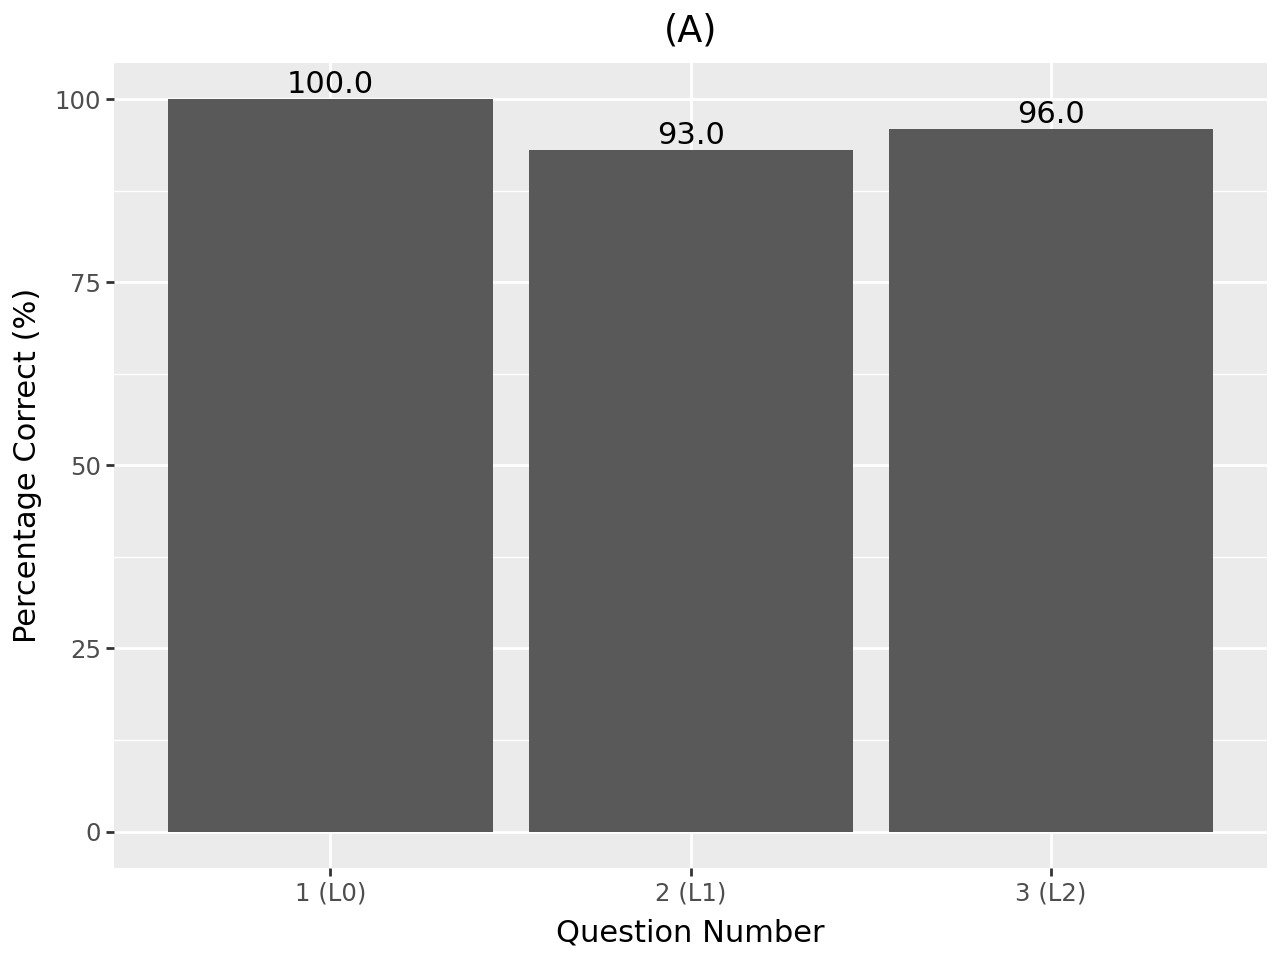

In [157]:
(ggplot(plot_q123, aes(x='question', y='correct'))
 + geom_bar(stat='identity')
 + labs(x='Question Number', 
        y='Percentage Correct (%)',
        title='(A)')
 + geom_text(aes(label='correct'), va='bottom')
)

In [ ]:
## Questions 4 - 5 -> Should be 'no' or 'no answer' (check 'no' in answer)
results_q456 = main_results[main_results['question'].isin(["4 (C bel of B)","5 (C Plan)", "6 (C going)"])]
results_q456['correct'] = [b.lower() in a for a, b in zip(results_q456['value'], results_q456['GroundTruth'])]


## Question 6 -> correct if not GroundTruth 
results_q456.loc[results_q456['question']=="6 (C going)", 'correct'] = ~results_q456[results_q456['question']=="6 (C going)"]['correct']

plot_q456_before = (results_q456[results_q456['ending']=="charC's Question"][['question','correct']].groupby('question')['correct']
             .mean()         
             .multiply(100)  # Convert to percentage
             .reset_index())
plot_q456_complete = (results_q456[results_q456['ending']=="charA's response (complete) "][['question','correct']].groupby('question')['correct']
             .mean()         
             .multiply(100)  # Convert to percentage
             .reset_index())
plot_q456_complete['correct'] = plot_q456_complete['correct'].round(1)

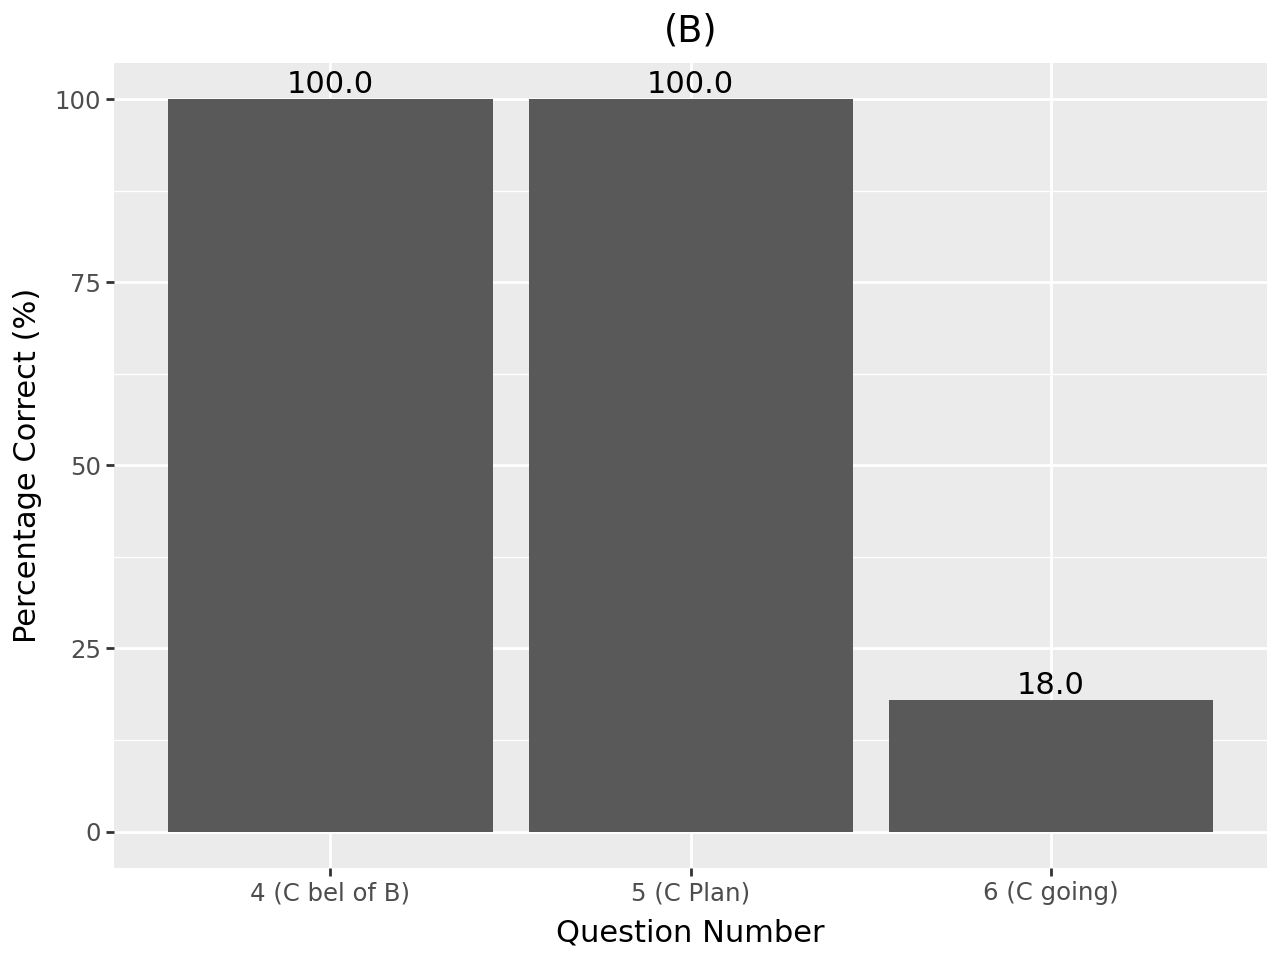

In [164]:
(ggplot(plot_q456_before, aes(x='question', y='correct'))
 + geom_bar(stat='identity')
 + labs(x='Question Number', 
        y='Percentage Correct (%)',
        title='(B)')
 + geom_text(aes(label='correct'), va='bottom')
)

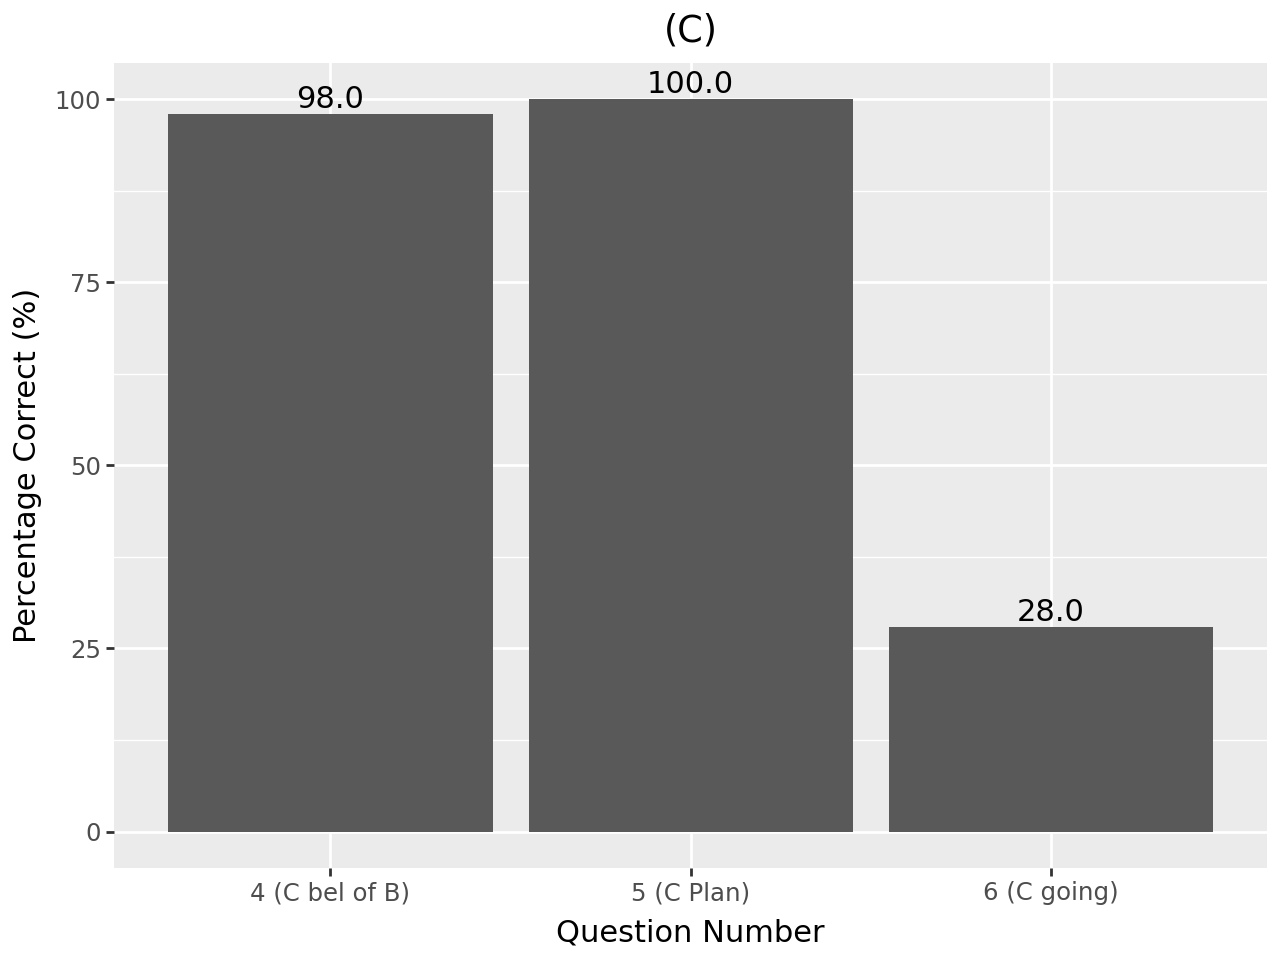

In [165]:
(ggplot(plot_q456_complete, aes(x='question', y='correct'))
 + geom_bar(stat='identity')
 + labs(x='Question Number', 
        y='Percentage Correct (%)',
        title='(C)')
 + geom_text(aes(label='correct'), va='bottom')
)

In [ ]:
#Check actual answers
pd.set_option('display.max_rows', 1000)
results_q456[results_q456['question']==6][['GroundTruth','value','correct']]

## Thinking Analysis Part

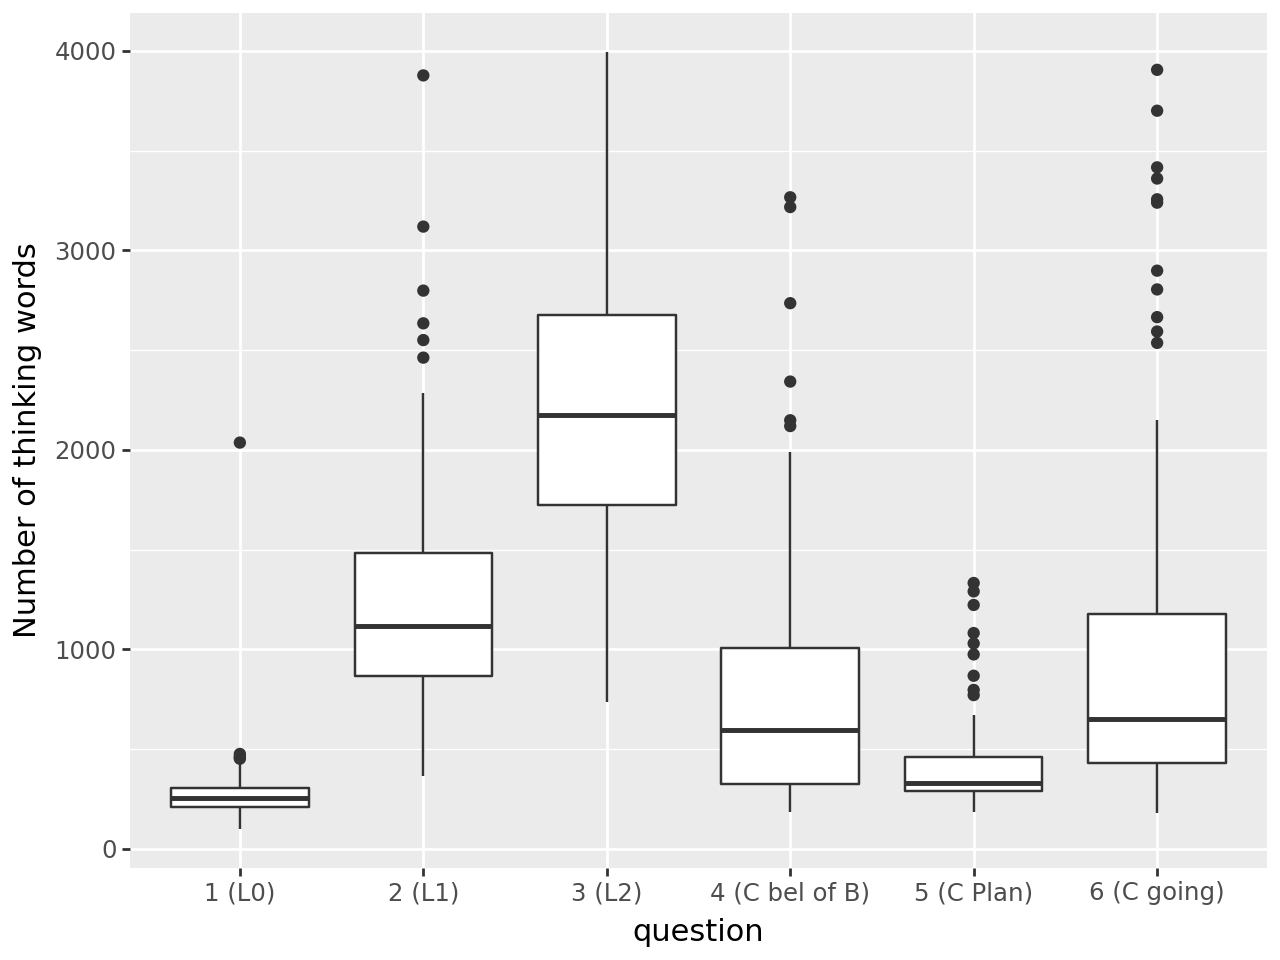

In [161]:
# Length 
thinking_results = results.melt(id_vars = ['theme','ending','question','GroundTruth'],
                           value_vars=['think 1', 'think 2','think 3', 'think 4', 'think 5'],
                           var_name = 'thinking', value_name='think_text')
thinking_results['think_len'] = thinking_results['think_text'].str.split().str.len()
thinking_results['question'] = thinking_results['question'].astype('category')
ggplot(thinking_results, aes(x='question',y='think_len')) + geom_boxplot() + labs(y='Number of thinking words')

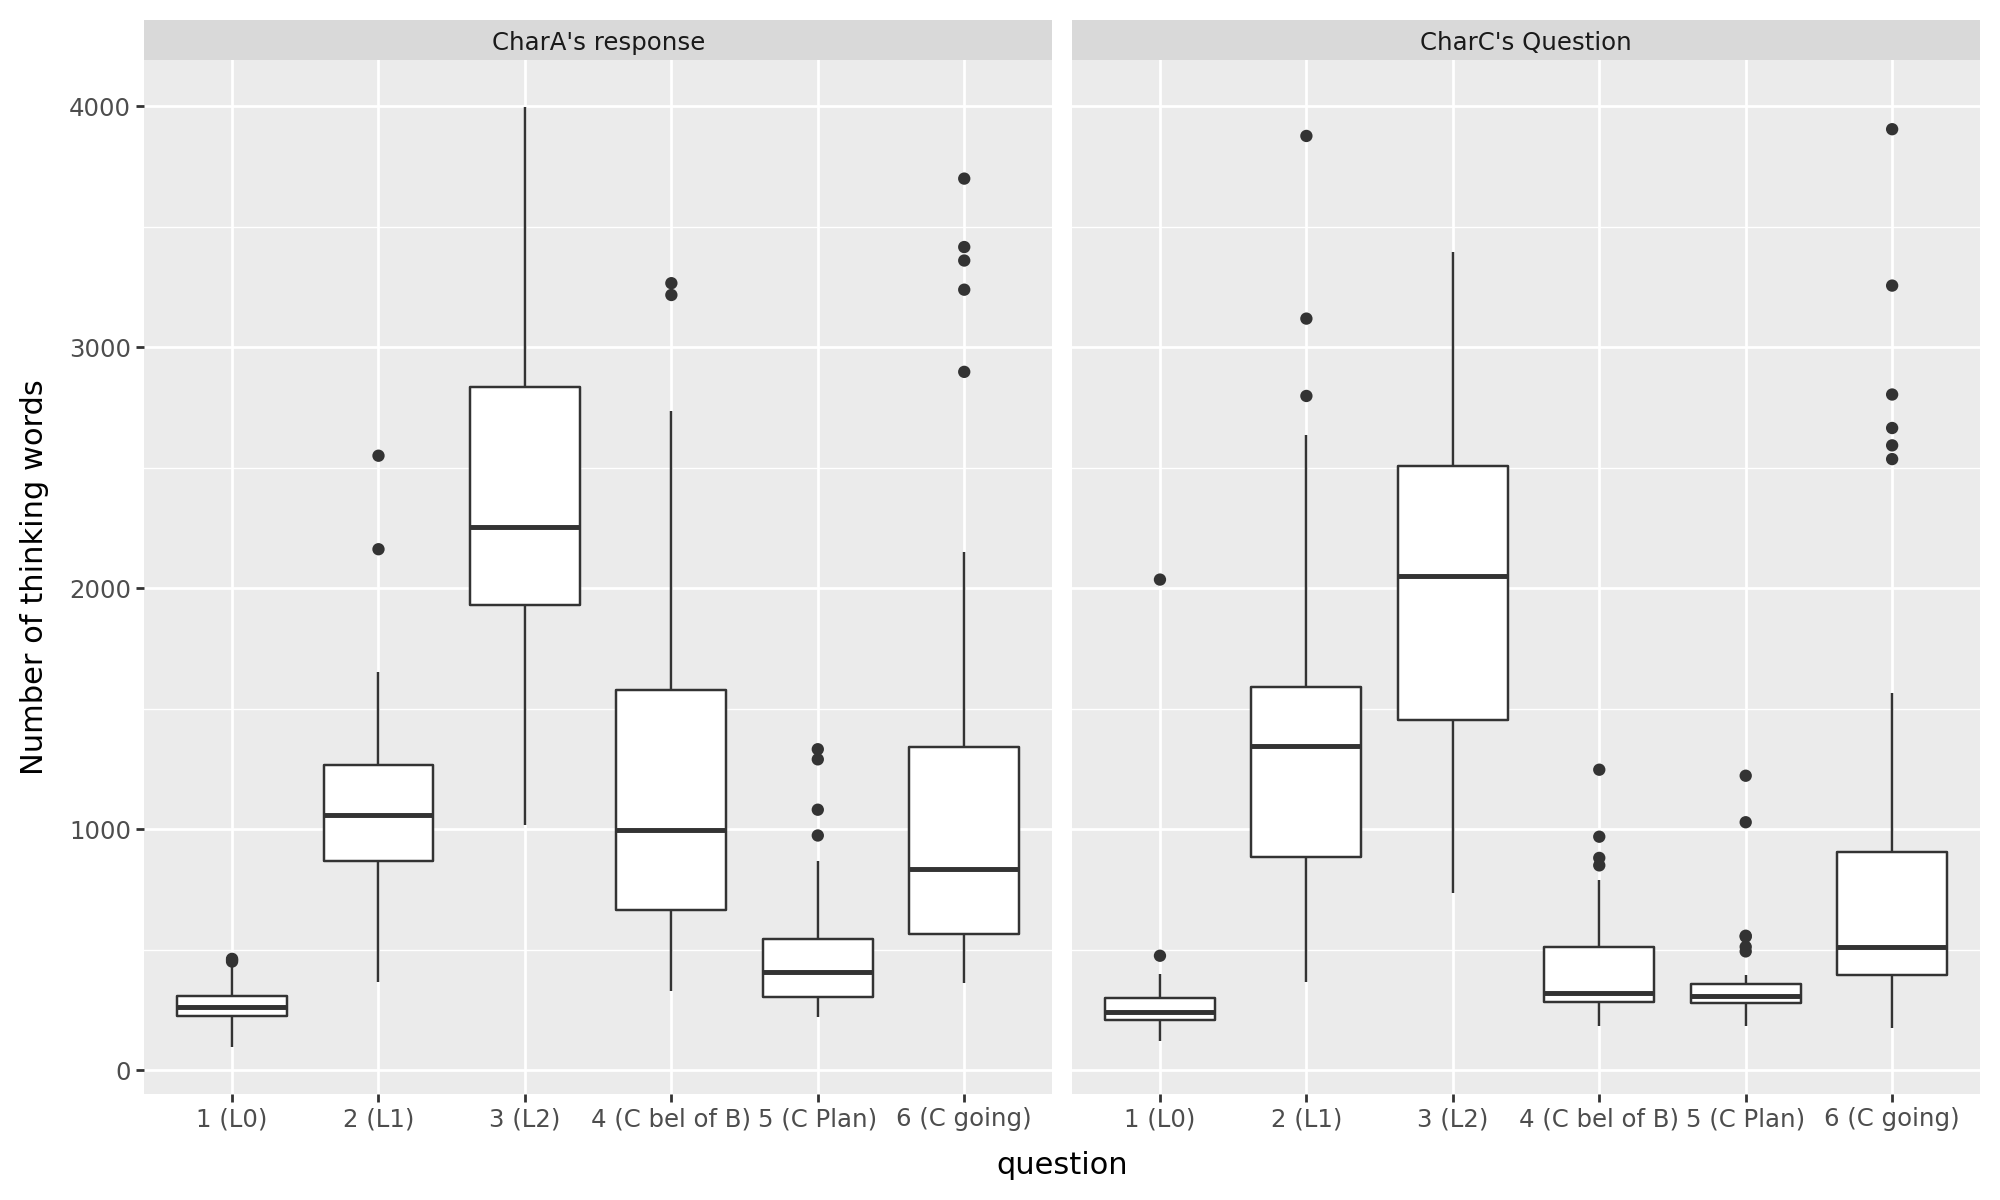

In [162]:
thinking_results['ending'] = thinking_results['ending'].replace({"charC's Question":"CharC's Question","charA's response (complete) ":"CharA's response"})
ggplot(thinking_results, aes(x='question',y='think_len')) + geom_boxplot() + labs(y='Number of thinking words') + facet_wrap('~ending') + theme(figure_size=(10,6))

### Common words

In [ ]:
# Common words
def analyze_text_by_question(df, text_column, question_column):
    # Define stopwords manually or use a simpler stopwords list
    stop_words = {'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 
                 'has', 'he', 'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 
                 'to', 'was', 'were', 'will', 'with', 'would', 'could', 
                 'get', 'also'}
    
    def get_word_counts(text):
        # Simple tokenization by splitting on spaces and punctuation
        words = str(text).lower()
        # Remove basic punctuation
        for char in '.,!?;:()[]{}""''':
            words = words.replace(char, ' ')
        # Split into words
        words = words.split()
        # Filter words
        words = [word for word in words 
                if word not in stop_words 
                and len(word) > 2
                and word.isalnum()]
        return Counter(words)
    
    # Group by question and aggregate word counts
    word_counts_by_question = df.groupby(question_column)[text_column].agg(
        lambda x: get_word_counts(' '.join(x))
    )
    
    return word_counts_by_question

# Get word counts by question
word_counts = analyze_text_by_question(thinking_results, 'think_text', 'question')

# Get number of answers per question
answers_per_question = thinking_results['question'].value_counts()

# Modify word counts to get averages
averaged_word_counts = pd.Series(index=word_counts.index)
for question, counts in word_counts.items():
    n_answers = answers_per_question[question]
    # Create new Counter with averaged values
    averaged_counts = Counter({word: count/n_answers for word, count in counts.items()})
    averaged_word_counts[question] = averaged_counts

# Word mappings 
word_mappings = {
    'knows': 'know',
    'known': 'know',
    'knowing': 'know',
    'thinks': 'think',
    'thinking': 'think',
    'thought': 'think'
}

def combine_word_forms(word_counts):
    """Combine different forms of words using the mapping dictionary"""
    combined_counts = Counter()
    for word, count in word_counts.items():
        transformed_word = word_mappings.get(word, word)
        combined_counts[transformed_word] += count
    return combined_counts

# Combine word forms with averaged counts
combined_averaged_counts = pd.Series(index=averaged_word_counts.index)
for idx, counts in averaged_word_counts.items():
    combined_averaged_counts[idx] = combine_word_forms(counts)

# Plotting
N = 10

# Create plot
plt.figure(figsize=(10, len(combined_averaged_counts)*2))

# Create subplots for each question
for i, (question, counts) in enumerate(combined_averaged_counts.items(), 1):
    top_words = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:N])
    
    plt.subplot(len(combined_averaged_counts), 1, i)
    plt.barh(list(top_words.keys()), list(top_words.values()))
    plt.title(f'Top {N} words for Question {question} (Average per Answer)')
    plt.xlabel('Average Frequency per Answer')

plt.tight_layout()
plt.show()

In [ ]:
# Modified heatmap function for averages
def create_word_frequency_heatmap(word_counts_series, top_n=10):
    # Get all unique words across all questions
    all_words = set()
    for counts in word_counts_series:
        all_words.update(counts.keys())
    
    # Get top N words by average frequency across all questions
    word_averages = {}
    for counts in word_counts_series:
        for word, count in counts.items():
            if word not in word_averages:
                word_averages[word] = []
            word_averages[word].append(count)
    
    # Calculate mean for each word
    word_means = {word: sum(counts)/len(counts) 
                 for word, counts in word_averages.items()}
    
    top_words = sorted(word_means.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_words = [word for word, _ in top_words]
    
    # Create matrix of frequencies
    data = []
    for counts in word_counts_series:
        row = [counts.get(word, 0) for word in top_words]
        data.append(row)
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(data, 
                xticklabels=top_words, 
                yticklabels=[f'Question {q}\n(n={answers_per_question[q]})' for q in word_counts_series.index],
                annot=True,
                fmt='.2f',  # Show 2 decimal places for averages
                cmap='YlOrRd')
    plt.title('Average Word Frequency per Answer by Question')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create heatmap with averaged counts
create_word_frequency_heatmap(combined_averaged_counts)

# Print statistics
print("\nNumber of answers per question:")
for question in combined_averaged_counts.index:
    n_answers = answers_per_question[question]
    print(f"Question {question}: {n_answers} answers")

print("\nTop words and their average frequency per answer:")
for question, counts in combined_averaged_counts.items():
    print(f"\nQuestion {question}:")
    top_words = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:N]
    for word, avg_count in top_words:
        print(f"{word}: {avg_count:.2f} times per answer")

C:\Users\nutju\AppData\Local\Temp\ipykernel_11496\2254280619.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\nutju\AppData\Local\Temp\ipykernel_11496\2254280619.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Counter({'john': 3.995122650982643, 'sam': 2.890546549992828, 'about': 1.158370391622436, 'master': 1.0974035289054658, 'but': 0.9934012336823986, 'story': 0.9575383732606514, 'heading': 0.7818103571940899, 'then': 0.7710514990675656, 'mike': 0.7638789269832161, 'wei': 0.7172572084349449, 'moving': 0.6527040596757998, 'there': 0.6491177736336251, 'truck': 0.609668627169703, 'where': 0.6060823411275283, 'library': 0.5809783388323053, 'learns': 0.5738057667479559, 'moved': 0.5666331946636065, 'te

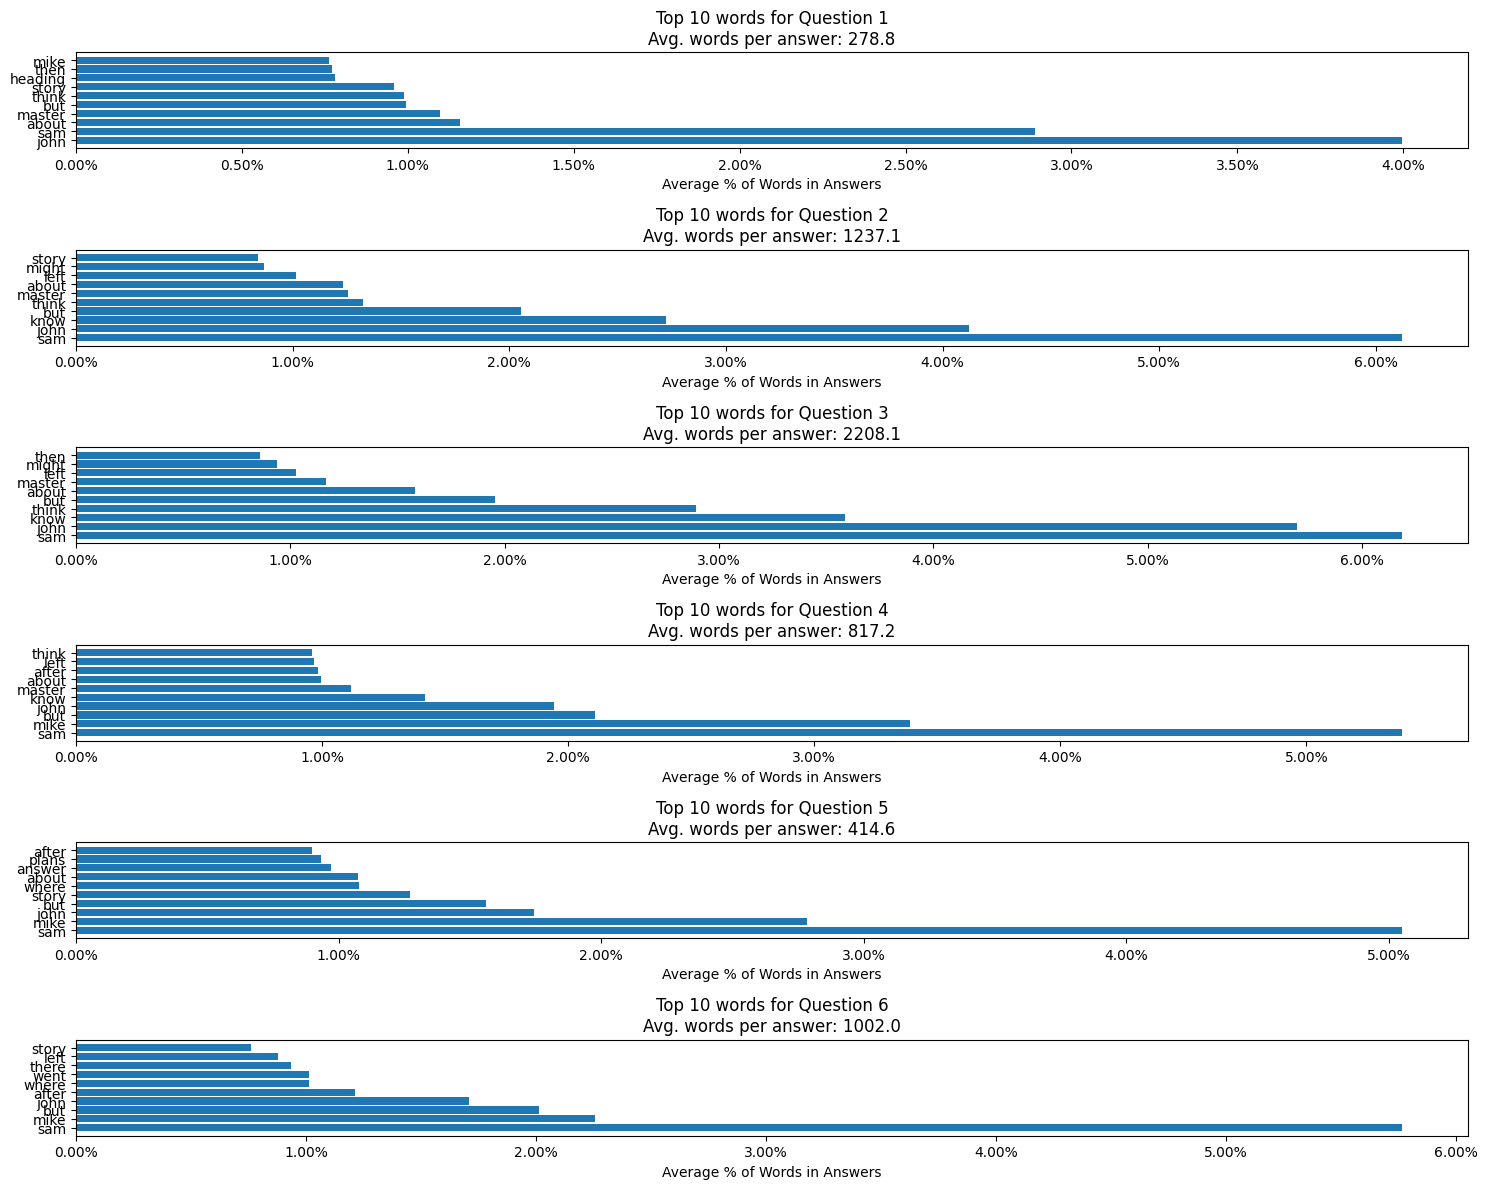

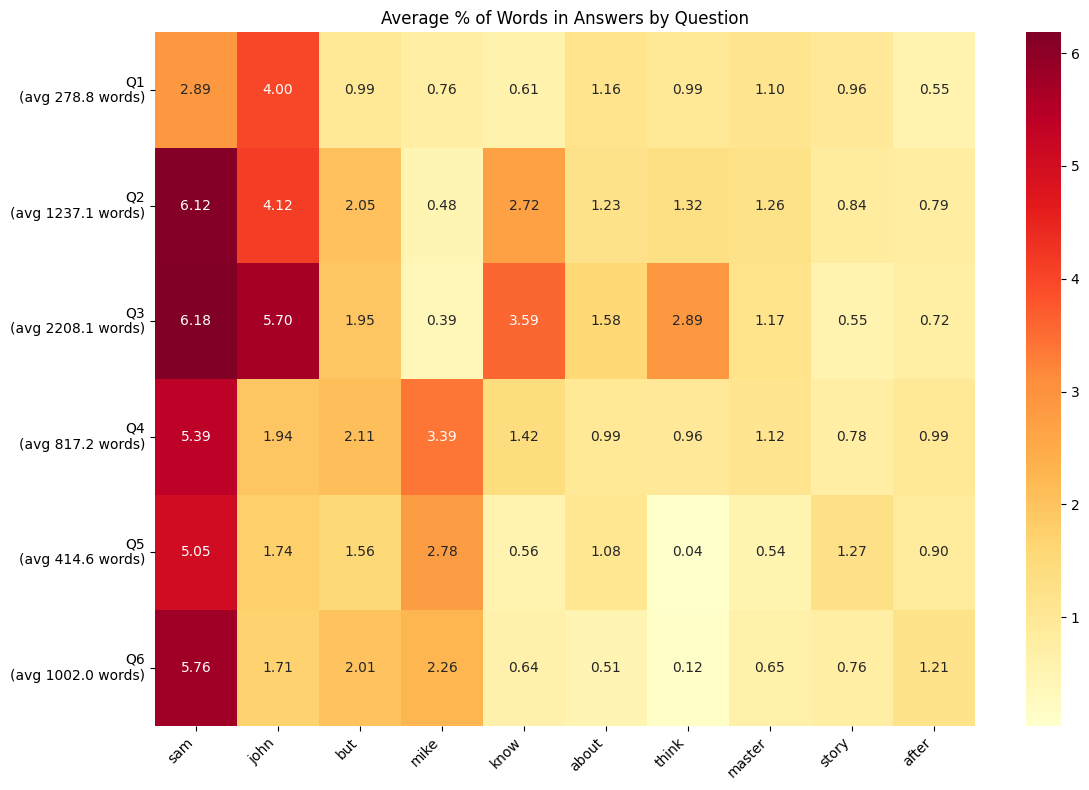


Statistics by question:

Question 1:
Average words per answer: 278.8
Top words (% of total words):
john: 4.00%
sam: 2.89%
about: 1.16%
master: 1.10%
but: 0.99%
think: 0.99%
story: 0.96%
heading: 0.78%
then: 0.77%
mike: 0.76%

Question 2:
Average words per answer: 1237.1
Top words (% of total words):
sam: 6.12%
john: 4.12%
know: 2.72%
but: 2.05%
think: 1.32%
master: 1.26%
about: 1.23%
left: 1.02%
might: 0.87%
story: 0.84%

Question 3:
Average words per answer: 2208.1
Top words (% of total words):
sam: 6.18%
john: 5.70%
know: 3.59%
think: 2.89%
but: 1.95%
about: 1.58%
master: 1.17%
left: 1.03%
might: 0.94%
then: 0.86%

Question 4:
Average words per answer: 817.2
Top words (% of total words):
sam: 5.39%
mike: 3.39%
but: 2.11%
john: 1.94%
know: 1.42%
master: 1.12%
about: 0.99%
after: 0.99%
left: 0.97%
think: 0.96%

Question 5:
Average words per answer: 414.6
Top words (% of total words):
sam: 5.05%
mike: 2.78%
john: 1.74%
but: 1.56%
story: 1.27%
where: 1.08%
about: 1.08%
answer: 0.97%
pla

In [146]:
def calculate_word_percentages(df, word_counts):
    # Get total words per answer
    def get_total_words(text):
        return len(str(text).split())
    
    # Calculate total words for each answer
    df['total_words'] = df['think_text'].apply(get_total_words)
    
    # Group by question to get average total words per answer
    avg_total_words = df.groupby('question')['total_words'].mean()
    
    # Calculate percentages
    percentage_word_counts = pd.Series(index=word_counts.index)
    for question, counts in word_counts.items():
        avg_words_per_answer = avg_total_words[question]
        # Convert counts to percentages of total words
        percentage_counts = Counter({
            word: (count/answers_per_question[question]/avg_words_per_answer)*100 
            for word, count in counts.items()
        })
        percentage_word_counts[question] = percentage_counts
    
    return percentage_word_counts, avg_total_words

# Get percentages
percentage_word_counts, avg_total_words = calculate_word_percentages(thinking_results, word_counts)


def combine_word_forms(word_counts):
    """Combine different forms of words using the mapping dictionary"""
    combined_counts = Counter()
    for word, count in word_counts.items():
        transformed_word = word_mappings.get(word, word)
        combined_counts[transformed_word] += count
    return combined_counts

# Combine word forms with percentages
combined_percentage_counts = pd.Series(index=percentage_word_counts.index)
for idx, counts in percentage_word_counts.items():
    combined_percentage_counts[idx] = combine_word_forms(counts)

# Plotting
N = 10

# Create plot
plt.figure(figsize=(15, len(combined_percentage_counts)*2))

# Create subplots for each question
for i, (question, counts) in enumerate(combined_percentage_counts.items(), 1):
    top_words = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:N])
    
    plt.subplot(len(combined_percentage_counts), 1, i)
    plt.barh(list(top_words.keys()), list(top_words.values()))
    plt.title(f'Top {N} words for Question {question}\nAvg. words per answer: {avg_total_words[question]:.1f}')
    plt.xlabel('Average % of Words in Answers')
    # Add percentage sign to x-axis labels
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}%'))

plt.tight_layout()
plt.show()

# Modified heatmap function for percentages
def create_word_frequency_heatmap(word_counts_series, top_n=10):
    # Get all unique words across all questions
    all_words = set()
    for counts in word_counts_series:
        all_words.update(counts.keys())
    
    # Get top N words by average percentage across all questions
    word_percentages = {}
    for counts in word_counts_series:
        for word, count in counts.items():
            if word not in word_percentages:
                word_percentages[word] = []
            word_percentages[word].append(count)
    
    # Calculate mean percentage for each word
    word_means = {word: sum(counts)/len(counts) 
                 for word, counts in word_percentages.items()}
    
    top_words = sorted(word_means.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_words = [word for word, _ in top_words]
    
    # Create matrix of percentages
    data = []
    for counts in word_counts_series:
        row = [counts.get(word, 0) for word in top_words]
        data.append(row)
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(data, 
                xticklabels=top_words, 
                yticklabels=[f'Q{q}\n(avg {avg_total_words[q]:.1f} words)' for q in word_counts_series.index],
                annot=True,
                fmt='.2f',  # Show 2 decimal places for percentages
                cmap='YlOrRd')
    plt.title('Average % of Words in Answers by Question')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create heatmap with percentages
create_word_frequency_heatmap(combined_percentage_counts)

# Print statistics
print("\nStatistics by question:")
for question in combined_percentage_counts.index:
    print(f"\nQuestion {question}:")
    print(f"Average words per answer: {avg_total_words[question]:.1f}")
    counts = combined_percentage_counts[question]
    top_words = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:N]
    print("Top words (% of total words):")
    for word, percentage in top_words:
        print(f"{word}: {percentage:.2f}%")